# Train the model

In [36]:
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import load_model
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
import seaborn as sns
import matplotlib.pyplot as plt


In [37]:
# load stage 3A test data as extra training set (avoid catastrophic forgetness)
# already normalized but thats probably ok
f_path = 'regression_training/stage1B/1A_test_X.txt'
X1 = pd.read_csv(f_path)
X1 = X1.drop(X1.columns[0],axis = 1)
X1 = X1.drop(0,axis = 0)

f_path = 'regression_training/stage1B/1A_test_y.txt'
y1 = pd.read_csv(f_path)
y1 = y1.drop(y1.columns[0],axis = 1)
y1 = y1.drop(0,axis = 0)

In [38]:
# load data
f_path = 'regression_training/stage1B/y.txt'
y = pd.read_csv(f_path)
y = y.drop(y.columns[0],axis = 1)
y = y.drop(0,axis = 0)

f_path = 'regression_training/stage1B/X.txt'
X = pd.read_csv(f_path)
X = X.drop(X.columns[0],axis = 1)
X = X.drop(0,axis = 0)

In [39]:
# append stage 1 and 2 data
y1.columns = ["m1","m2"]
yy = pd.concat([y, y1],axis=0,ignore_index=True)
XX = pd.concat([X, X1],axis=0,ignore_index=True)

In [40]:
X_t = XX.transpose()
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_t)
X_scaled = pd.DataFrame(X_scaled.transpose())

In [41]:
# Train test split with sklearn
Xtrain,Xtest,y_train,y_test = train_test_split(X_scaled.values,yy.values,test_size=0.1,random_state=13)

In [43]:
# Reshape data
X_train = []
for i in np.arange(len(Xtrain)):
    h = Xtrain[i].reshape(4096,1)
    X_train.append(h)
X_train = np.asarray(X_train)

X_test = []
for i in np.arange(len(Xtest)):
    h = Xtest[i].reshape(4096,1)
    X_test.append(h)
X_test = np.asarray(X_test)

In [42]:
# Check model performance accuracy before

model = load_model("regression_stage1A.h5")
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss 1:', score[0])
print('Test accuracy 1:', score[1])

554/554 [==============================] - 2s 3ms/step
Test loss 1: 2.9958690856768335
Test accuracy 1: 19.367938775017805


In [44]:
# Continue training
epoch = 200
batch_size = 5

earlystopping_callback = EarlyStopping(monitor='mean_squared_error',verbose=1,min_delta=0.5,patience=3,baseline=None)

record = model.fit(X_train, y_train, validation_split = 0.20, batch_size=batch_size, epochs=epoch, verbose=1,
                   callbacks=[earlystopping_callback])

Train on 3984 samples, validate on 997 samples
Epoch 1/200
3984/3984 [==============================] - 45s 11ms/step - loss: 2.2129 - mean_squared_error: 9.7938 - mean_absolute_error: 2.2129 - val_loss: 2.1630 - val_mean_squared_error: 8.8116 - val_mean_absolute_error: 2.1630
Epoch 2/200
3984/3984 [==============================] - 42s 11ms/step - loss: 1.9238 - mean_squared_error: 7.5920 - mean_absolute_error: 1.9238 - val_loss: 1.6479 - val_mean_squared_error: 6.6007 - val_mean_absolute_error: 1.6479
Epoch 3/200
3984/3984 [==============================] - 44s 11ms/step - loss: 1.8208 - mean_squared_error: 6.9595 - mean_absolute_error: 1.8208 - val_loss: 1.7892 - val_mean_squared_error: 7.3178 - val_mean_absolute_error: 1.7892
Epoch 4/200
3984/3984 [==============================] - 50s 13ms/step - loss: 1.7284 - mean_squared_error: 6.4179 - mean_absolute_error: 1.7284 - val_loss: 2.5109 - val_mean_squared_error: 12.3470 - val_mean_absolute_error: 2.5109
Epoch 5/200
3984/3984 [=====

In [45]:
# Save model
model.save('regression_stage1B.h5')  # creates a HDF5 file 'my_model.h5'

In [46]:
# Save test data
X_test_df = pd.DataFrame(Xtest)
f_path = 'regression_training/stage1C/1B_test_X.txt'
X_test_df.to_csv(f_path)
y_test_df = pd.DataFrame(y_test)
f_path = 'regression_training/stage1C/1B_test_y.txt'
y_test_df.to_csv(f_path)

dict_keys(['val_loss', 'val_mean_squared_error', 'val_mean_absolute_error', 'loss', 'mean_squared_error', 'mean_absolute_error'])


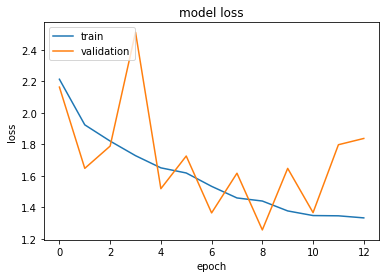

In [47]:
print(record.history.keys())
# "Loss"
plt.plot(record.history['loss'])
plt.plot(record.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Prediction

/Users/DRRRR/anaconda/envs/machinelearning/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


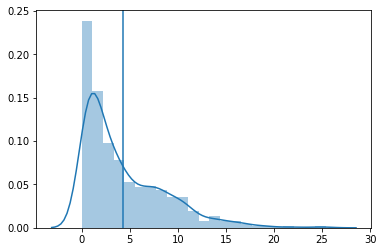

Mean %difference: 4.339696706190364
Standard deviation of %difference: 4.249166282758286


In [48]:
preds = model.predict(X_test)
 
# compute the difference between the *predicted* and *actual* 
# then compute the percentage difference and the absolute percentage difference
diff = preds.flatten() - y_test.flatten()
percentDiff = (diff / y_test.flatten()) * 100
absPercentDiff = np.abs(percentDiff)
 
# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

sns.distplot(absPercentDiff)
plt.axvline(mean, 0,1)
plt.show()

print("Mean %difference:",mean)
print("Standard deviation of %difference:",std)

In [57]:
absPercentD = absPercentDiff.reshape(len(y_test),2)
count = 0
percentage_cut = 15

grad = []
badmass = []


for i in np.arange(len(absPercentD)):
    if absPercentD[i][0]>percentage_cut or absPercentD[i][1]>percentage_cut:
        count += 1
        grad.append(max(absPercentD[i][0],absPercentD[i][1]))
        badmass.append(y_test[i])
        print()
        print("Absolute Percent Difference: ",absPercentD[i])
        print("Actual masses: ",y_test[i])
        print("Predicted masses: ",preds[i])

print()
print("A total number of ", count, " predictions have above ", percentage_cut, " absolute percent difference.")


Absolute Percent Difference:  [16.58254468  2.78988006]
Actual masses:  [10.59369562 79.53968899]
Predicted masses:  [ 8.836991 81.75875 ]

Absolute Percent Difference:  [15.58732104 16.48975943]
Actual masses:  [31.88099281 32.6514593 ]
Predicted masses:  [26.9116   38.035606]

Absolute Percent Difference:  [20.0496733  19.24128587]
Actual masses:  [63.80203733 63.88813853]
Predicted masses:  [51.009937 76.18104 ]

Absolute Percent Difference:  [25.40589509  6.37520296]
Actual masses:  [10.18637008 70.3557789 ]
Predicted masses:  [ 7.5984316 74.8411   ]

Absolute Percent Difference:  [15.25139332 14.60291142]
Actual masses:  [31.89969139 34.13342344]
Predicted masses:  [27.034544 39.117897]

Absolute Percent Difference:  [18.50276742  3.26909799]
Actual masses:  [10.25395371 83.29964208]
Predicted masses:  [ 8.3566885 86.02279  ]

Absolute Percent Difference:  [16.55380186 16.24591068]
Actual masses:  [32.62460364 33.3938401 ]
Predicted masses:  [27.223991 38.818974]

Absolute Percen

In [58]:
# make panda dataframe
summary = pd.DataFrame(badmass,columns = ["m1","m2"])
summary['percentage']=grad

Blues = plt.get_cmap('Blues')
norm = [float(i)/max(grad) for i in grad]
colors = [Blues(c) for c in norm]

summary['colors']=colors

# For stage 1B data generation

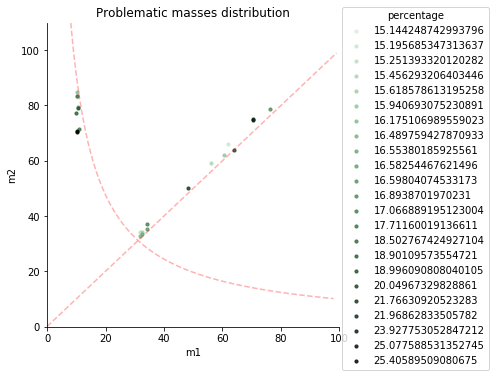

In [59]:
# Summary for training data 1B:

sns.lmplot(x="m1", y="m2",
           hue="percentage",
           data = summary,
           fit_reg=False,
           scatter_kws={"marker": "D",
                        "s": 10},
           palette = sns.cubehelix_palette(len(colors), start=2, rot=0, dark=0, light=.9))

plt.plot(np.arange(100),'r--',alpha=0.3)
plt.plot(1000/np.arange(1,100),'r--',alpha=0.3)

plt.title('Problematic masses distribution')
plt.xlabel('m1')
plt.ylabel('m2')
plt.ylim(0,110)
plt.xlim(0,100)
plt.show()